In [1]:
#!pip install -U gensim

In [2]:
import pandas as pd ; import networkx as nx ; import ast ; import matplotlib.pyplot as plt ; import numpy as np ;
import nltk ; from wordcloud import WordCloud, ImageColorGenerator ; from PIL import Image ; import urllib.request ;
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS ; from collections import Counter ; import seaborn as sns ;
from math import pi

In [3]:
%matplotlib inline
sns.set()

In [4]:
# Dataframe of Characters
df_characters = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_characters_wRelationsAndAttributes_final.csv")
#df_characters = df_characters.drop('Unnamed: 0', axis=1)
# Dataframe of Episodes
df_episodes = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_episodes.csv')
# Dataframe of Transcripts
df_transcripts = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/transcripts/RickAndMortyScripts.csv")
# Dataframe of Sentiments of words
df_nrc = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/NRC.csv")
df_nrc_01 = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/lexicons/NRC_sentiment_lexicon.csv')

In [5]:
# Replacing the names of some characters at df_transcripts to match the names in df_characters
df_transcripts["name"].replace({"Rick": "Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Evil Rick": "Evil Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Pickle Rick": "Pickle Rick (character)"}, inplace=True)
df_transcripts["name"].replace({"Morty": "Morty Smith"}, inplace=True)
df_transcripts["name"].replace({"Beth": "Beth Smith"}, inplace=True)
df_transcripts["name"].replace({"Jerry": "Jerry Smith"}, inplace=True)
df_transcripts["name"].replace({"Summer": "Summer Smith"}, inplace=True)
df_transcripts["name"].replace({"'Rick D716-B": "Rick D716-B"}, inplace=True)


# Sentiment Analysis: Characters

In [6]:
# A dataframe with all the lines of each character
df_charLines = df_transcripts.groupby(['name'], as_index = False).agg({'line': ' '.join})
#Remove stopwords
df_charLines.line = df_charLines.line.apply(lambda x: remove_stopwords(x))

In [7]:
# A dictionary with all the lines of each character
characters_dialogue = df_charLines.set_index('name').T.to_dict('records')[0]


In [8]:
# Save as a csv
#df_charLines.to_csv('df_char_lines.csv', index=False)

## Sentiments per Character

In [9]:
from nltk.tokenize import RegexpTokenizer

def get_list_of_tokens(aSentence):
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    # Match the word with the relevant sentiments 
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    #Combine in a dict the weight of sentiments for a list of tokens
    sentiment_list = []
    sentiment_dict = {'positive': 0, 'negative': 0, 'trust': 0, 'anticipation': 0, 'fear': 0, 'joy': 0, 'anger': 0, 'disgust': 0, 'sadness': 0, 'surprise': 0}
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)   
            sentiment_list.extend(sentiment)
        dd = dict(Counter(sentiment_list))
        d =  {k: dd.get(k, 0) + sentiment_dict.get(k, 0) for k in sentiment_dict.keys()}
    else:
        d = sentiment_dict  
    return d


In [10]:
# Calculate the NRC sentiment score for each character

sentiment_NRC_list = []
count_list = []

def calculate_NRC_sentiment_of_a_character(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        #print([calculate_nrc_sentiments(get_list_of_tokens(aSentence)) for aSentence in characters_dialogue[aRow.Name]])
        sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(characters_dialogue[aRow.Name]))
        
        count = 0
        for word in get_list_of_tokens(characters_dialogue[aRow.Name]):
            if (word in list(df_nrc.word)):
                count+=1
        
        
        sentiment_NRC_list.append(sentiment_NRC) 
        count_list.append(count)
        
    else:
        sentiment_NRC_list.append(None)
        count_list.append(None)



_ = df_characters.apply(calculate_NRC_sentiment_of_a_character, axis=1)

# store in dataframe of characters as a new column
df_characters['NRC_score'] = sentiment_NRC_list
df_characters['NRC_words'] = count_list
df_NRC = df_characters[df_characters.NRC_score.notnull()]   # df_NRC.count() = 80
df_NRC = df_NRC[df_NRC.NRC_words != 0]

In [11]:
NRC_emotions_list = []
positive_list = []
negative_list = []
positive_portion_list = []
negative_portion_list = []
NRC_emotions_portion_list = [] 


def calculate_NRC_portions_of_a_character(aRow):
        
    dictChar = df_NRC[df_NRC.Name == aRow.Name]['NRC_score'].values[0]
    
    positive = dictChar['positive'] + dictChar['trust'] + dictChar['anticipation'] + dictChar['joy'] + dictChar['surprise']
    negative = dictChar['negative'] + dictChar['fear'] + dictChar['anger'] + dictChar['disgust'] + dictChar['sadness']
    keys = list(dictChar.keys())
    keys.remove('positive')
    keys.remove('negative')
    emotions_dict  =  { k: dictChar[k] for k in keys}
    
    count = df_NRC[df_NRC.Name == aRow.Name]['NRC_words'].values[0]
            
    emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
    positive_portion = positive / (positive + negative) * 100
    negative_portion = negative / (positive + negative) * 100
    
    
    NRC_emotions_list.append(emotions_dict)
    NRC_emotions_portion_list.append(emotions_portion_dict)
    positive_list.append(positive)
    negative_list.append(negative)
    positive_portion_list.append(positive_portion)
    negative_portion_list.append(negative_portion)
    


    
_ = df_NRC.apply(calculate_NRC_portions_of_a_character, axis=1)

# store in dataframe of characters as a new column
df_NRC['Positive'] = positive_list
df_NRC['Positive_portion'] = positive_portion_list
df_NRC['Negative'] = negative_list
df_NRC['Negative_portion'] = negative_portion_list
df_NRC['Emotions'] = NRC_emotions_list
df_NRC['Emotions_portion'] = NRC_emotions_portion_list


In [12]:
def sort_dict(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True)}


In [13]:
# Plots for each character's sentiments
   
def piechart_characters_sentiments(name):
    
    labels = 'Positive', 'Negative'
    sizes = [df_NRC[df_NRC.Name == name]['Positive'].values[0], df_NRC[df_NRC.Name == name]['Negative'].values[0]]
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
    ax.axis('equal')  
    ax.set_title(name + ': Sentiments')

    
    
def plot_seaborn_character_emotions(name):

    #keys = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise'] # emotions
  
    d = df_NRC[df_NRC.Name == name]['Emotions_portion'].tolist()[0]
    #d = {k: v for k, v in d.items() if k in keys}
    d = sort_dict(d)
    f, ax = plt.subplots()   #, sharex=True)
    y = list(d.keys())
    x = list(d.values())  # weight 
    #x = list(map(d.get, y)) # weight 
    sns.set(rc = {'figure.figsize':(5,5)})
    sns.barplot(x=x, y=y, palette="deep", ax=ax) 
    ax.set_xlabel('Percentage (%)')
    ax.invert_yaxis()  # labels read top-to-bottom
    #ax.set_title('Sentiment Analysis: ' + name)
    #count_words = df_NRC[df_NRC.Name == name]['NRC_words_count'].values[0]
    count_words = df_NRC[df_NRC.Name == name]['NRC_words'].values[0]
    ax.set_title(name + ': Emotions')
    #ax.set_title(name + ': Emotions  (' + str(count_words) + ' NRC words)')
    ax.set_xlim([0, 50])
    ax.invert_yaxis() 

      
 

(None,)

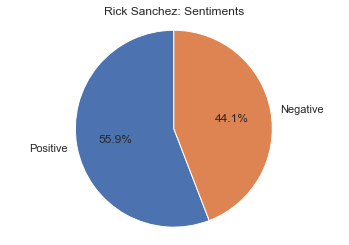

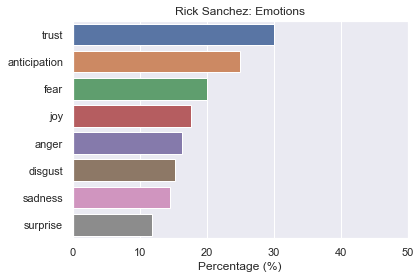

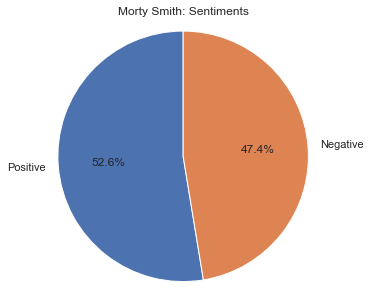

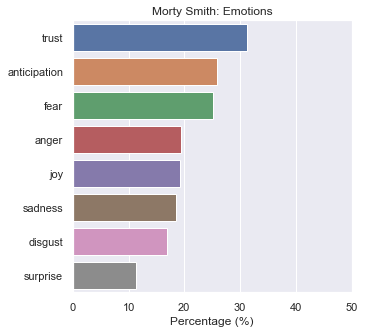

In [14]:
piechart_characters_sentiments('Rick Sanchez'),
plot_seaborn_character_emotions('Rick Sanchez')
piechart_characters_sentiments('Morty Smith'),
plot_seaborn_character_emotions('Morty Smith'),
# piechart_characters_sentiments('Summer Smith'),
# plot_seaborn_character_emotions('Summer Smith'),
# piechart_characters_sentiments('Beth Smith'),
# plot_seaborn_character_emotions('Beth Smith')
# piechart_characters_sentiments('Jerry Smith'),
# plot_seaborn_character_emotions('Jerry Smith')

## Top characters for each sentiment

In [15]:
# Filtering df_NRC to keep only those with more than 10 nrc words
df_NRC_filtered = df_NRC[df_NRC.NRC_words > 50]

sent_dict = {}

def a_sentiment_for_a_character(aRow, sentiment):
    if sentiment == 'positive':
        sent_dict[aRow.Name] = round(aRow.Positive_portion,2)
    elif sentiment == 'negative':    
        sent_dict[aRow.Name] = round(aRow.Negative_portion, 2)
    else:    
        sent_dict[aRow.Name] = round(aRow.Emotions_portion[sentiment], 2)

def top_characters_for_a_sentiment(sentiment):
    _ = df_NRC_filtered.apply(lambda x: a_sentiment_for_a_character(x, sentiment), axis=1)     


In [16]:
def print_top_10(sentiment):
    top_characters_for_a_sentiment(sentiment)
    d = sort_dict(sent_dict)
    #print(dict(list(d.items())[:10]))
    d1 = dict(list(d.items())[:10])

    i=1
    for k, v in d1.items():
        print("{}. {} ({}%)".format(i, k, v))
        i+=1

In [17]:
sentiments = {'positive', 'negative', 'trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise'}
for sent in sentiments:
    print(sent+':\n')
    print_top_10(sent)
    print('\n')

positive:

1. Principal Vagina (82.64%)
2. Mr. Goldenfold (67.83%)
3. Jerry Smith (59.77%)
4. Beth Smith (59.16%)
5. Summer Smith (58.0%)
6. Rick Sanchez (55.85%)
7. Pickle Rick (character) (55.64%)
8. Unity (54.59%)
9. Morty Smith (52.59%)
10. Dr. Wong (46.0%)


trust:

1. Principal Vagina (61.11%)
2. Mr. Goldenfold (45.45%)
3. Summer Smith (38.6%)
4. Beth Smith (36.41%)
5. Unity (32.88%)
6. Jerry Smith (32.15%)
7. Morty Smith (31.32%)
8. Rick Sanchez (30.06%)
9. Dr. Wong (26.67%)
10. Pickle Rick (character) (25.0%)


joy:

1. Mr. Goldenfold (30.91%)
2. Principal Vagina (29.63%)
3. Summer Smith (24.42%)
4. Unity (23.29%)
5. Jerry Smith (23.01%)
6. Pickle Rick (character) (21.77%)
7. Beth Smith (20.51%)
8. Morty Smith (19.17%)
9. Dr. Wong (18.33%)
10. Rick Sanchez (17.61%)


fear:

1. Dr. Wong (36.67%)
2. Unity (32.88%)
3. Summer Smith (27.67%)
4. Morty Smith (25.2%)
5. Pickle Rick (character) (21.77%)
6. Toxic Rick (21.18%)
7. Beth Smith (20.26%)
8. Rick Sanchez (19.98%)
9. Mr. Golden

## Histograms for all characters' sentiments

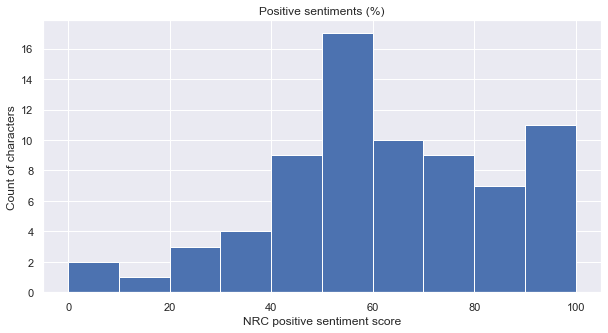

In [18]:
plt.figure(figsize=(10,5))
plt.hist(df_NRC.Positive_portion)
plt.title("Positive sentiments (%)")
plt.xlabel("NRC positive sentiment score")
plt.ylabel("Count of characters")
plt.show()



## Comparison of different characters' sentiments

In [19]:
def grouped_bar_chart_for_characters_sentiments(characters_list):


    characters = []
    sentiments = []
    score = []
    
    for c in characters_list:
        
        positive = df_NRC[df_NRC.Name == c ].Positive_portion.tolist()[0]
        characters.append(c)
        sentiments.append('Positive')
        score.append(positive)
        
        negative = df_NRC[df_NRC.Name == c ].Negative_portion.tolist()[0]
        characters.append(c)
        sentiments.append('Negative')
        score.append(negative)


    # assign data of lists.  
    data = {'Name': characters, 'Sentiment': sentiments, 'Score': score}  

    # Create DataFrame  
    df_chars_sentiments = pd.DataFrame(data)     
    
    sns.set(rc = {'figure.figsize':(20,15)})
    g = sns.catplot(
        data=df_chars_sentiments, kind="bar",
        x="Name", y="Score", hue="Sentiment",
        ci="sd", palette="dark", alpha=.6, height=5, aspect=10/5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Weight (%)")
    g.legend.set_title("Sentiments")
    

def grouped_bar_chart_for_characters_emotions(characters_list):

    keys = []
    values = []
    characters = []

    for c in characters_list:
        d = df_NRC[df_NRC.Name == c ].Emotions_portion.tolist()[0]

        for item in d.items():
            characters.append(c), keys.append(item[0]), values.append(item[1])

    # assign data of lists.  
    data = {'Name': characters, 'Emotion': keys, 'Score': values}  

    # Create DataFrame  
    df_chars_emotions = pd.DataFrame(data)     
    sns.set(rc = {'figure.figsize':(20,15)})
    g = sns.catplot(
        data=df_chars_emotions, kind="bar",
        x="Name", y="Score", hue="Emotion",
        ci="sd", palette="dark", alpha=.6, height=5, aspect=11.7/5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Weight (%)")
    g.legend.set_title("Emotions")

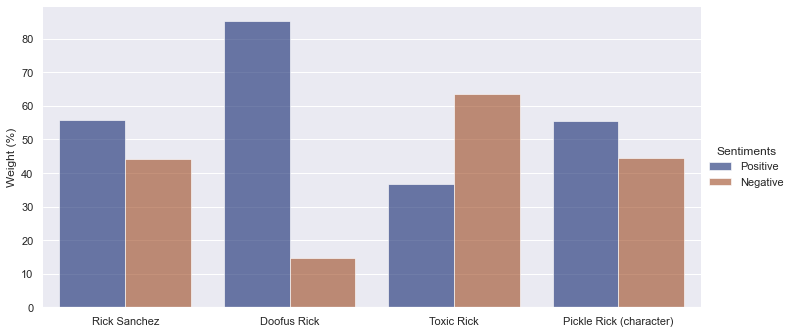

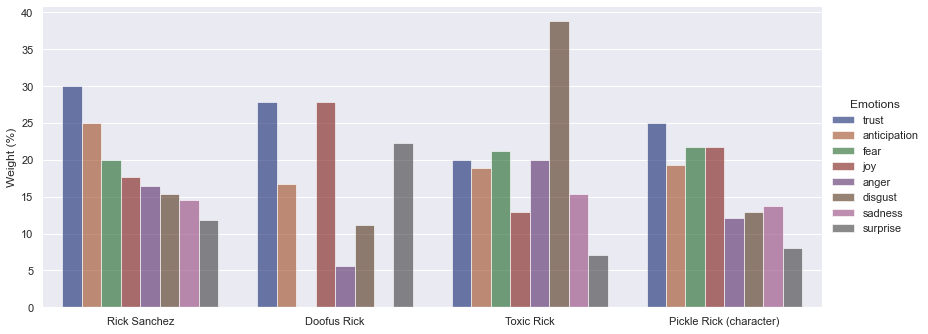

In [20]:
Ricks = ['Rick Sanchez', 'Doofus Rick', 'Toxic Rick', 'Pickle Rick (character)']
grouped_bar_chart_for_characters_sentiments(Ricks),
grouped_bar_chart_for_characters_emotions(Ricks)


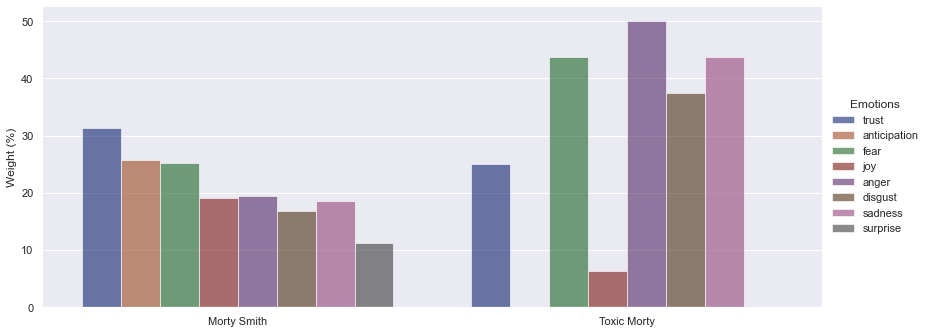

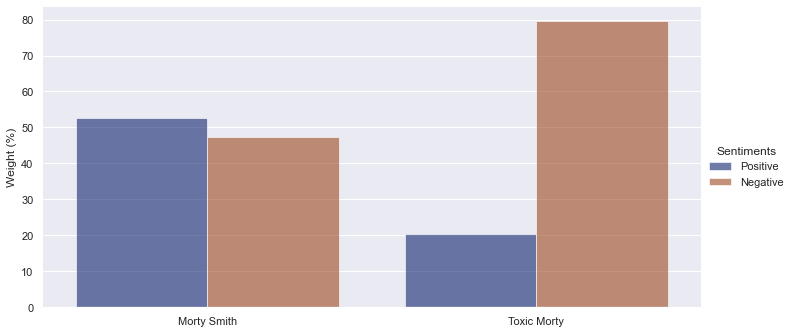

In [21]:
Mortys = ['Morty Smith', 'Toxic Morty']

grouped_bar_chart_for_characters_emotions(Mortys),
grouped_bar_chart_for_characters_sentiments(Mortys)


# Sentiment Analysis: Episodes

In [22]:
df_episode_transcript = df_transcripts.groupby(['season no.', 'episode no.', 'episode name'], as_index = False).agg({'line': ' '.join})
df_episode_lines = df_transcripts.groupby(['season no.', 'episode no.', 'episode name'], as_index = False).agg({'line': ' '.join})
df_episode_lines.line = df_episode_lines.line.apply(lambda x: remove_stopwords(x))
episodes_dialogue = df_episode_lines.set_index(['season no.', 'episode no.', 'episode name']).T.to_dict('records')[0]

In [23]:
from nltk.tokenize import RegexpTokenizer

def get_list_of_tokens(aSentence):
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    # Match the word with the relevant sentiments 
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    #Combine in a dict the weight of sentiments for a list of tokens
    sentiment_list = []
    sentiment_dict = {'positive': 0, 'negative': 0, 'trust': 0, 'anticipation': 0, 'fear': 0, 'joy': 0, 'anger': 0, 'disgust': 0, 'sadness': 0, 'surprise': 0}
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)   
            sentiment_list.extend(sentiment)
        dd = dict(Counter(sentiment_list))
        d =  {k: dd.get(k, 0) + sentiment_dict.get(k, 0) for k in sentiment_dict.keys()}
    else:
        d = sentiment_dict  
    return d


In [24]:
# Calculate the NRC sentiment score for each character

sentiment_NRC_list = []
count_list = []

def calculate_NRC_sentiment_of_an_episode(aRow):
    if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(episodes_dialogue.keys()):
        sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
        
        count = 0
        for word in get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
            if (word in list(df_nrc.word)):
                count+=1
        
        
        sentiment_NRC_list.append(sentiment_NRC) 
        count_list.append(count)
        
    else:
        sentiment_NRC_list.append(None)
        count_list.append(None)



_ = df_episode_lines.apply(calculate_NRC_sentiment_of_an_episode, axis=1)


# store in dataframe of characters as a new column
df_episode_lines['NRC_score'] = sentiment_NRC_list
df_episode_lines['NRC_words'] = count_list
df_NRC_episodes = df_episode_lines[df_episode_lines.NRC_score.notnull()]
df_NRC_episodes = df_NRC_episodes[df_NRC_episodes.NRC_words != 0]

In [25]:
NRC_emotions_list = []
positive_list = []
negative_list = []
positive_portion_list = []
negative_portion_list = []
NRC_emotions_portion_list = [] 


def calculate_NRC_portions_of_an_episode(aRow):
        
    dictEp = df_NRC_episodes[df_NRC_episodes['episode name'] == aRow['episode name']]['NRC_score'].values[0]
    
    positive = dictEp['positive'] + dictEp['trust'] + dictEp['anticipation'] + dictEp['joy'] + dictEp['surprise']
    negative = dictEp['negative'] + dictEp['fear'] + dictEp['anger'] + dictEp['disgust'] + dictEp['sadness']
    keys = list(dictEp.keys())
    keys.remove('positive')
    keys.remove('negative')
    emotions_dict  =  { k: dictEp[k] for k in keys}
    
    count = df_NRC_episodes[df_NRC_episodes['episode name'] == aRow['episode name']]['NRC_words'].values[0]
            
    emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
    positive_portion = positive / (positive + negative) * 100
    negative_portion = negative / (positive + negative) * 100
    
    
    NRC_emotions_list.append(emotions_dict)
    NRC_emotions_portion_list.append(emotions_portion_dict)
    positive_list.append(positive)
    negative_list.append(negative)
    positive_portion_list.append(positive_portion)
    negative_portion_list.append(negative_portion)
    


    
_ = df_NRC_episodes.apply(calculate_NRC_portions_of_an_episode, axis=1)

# store in dataframe of characters as a new column
df_NRC_episodes['Positive'] = positive_list
df_NRC_episodes['Positive_portion'] = positive_portion_list
df_NRC_episodes['Negative'] = negative_list
df_NRC_episodes['Negative_portion'] = negative_portion_list
df_NRC_episodes['Emotions'] = NRC_emotions_list
df_NRC_episodes['Emotions_portion'] = NRC_emotions_portion_list


In [26]:
# Plots for sentiments in an episode
   
def piechart_episode_sentiments(season, episode):
    
    labels = 'Positive', 'Negative'
    positive = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Positive'].values[0]
    negative = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Negative'].values[0]
    sizes = [positive, negative]
    plt.figure(figsize=(10,5))
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
    ax.axis('equal')  
    ax.set_title('Season ' + str(season) + ', Episode ' + str(episode) + ': Sentiments')

    

def plot_seaborn_episode_emotions(season, episode):
  
    d = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['Emotions_portion'].tolist()[0]
    d = sort_dict(d)
    f, ax = plt.subplots() 
    y = list(d.keys())
    x = list(d.values())  # weight 
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.barplot(x=x, y=y, palette="deep", ax=ax) 
    ax.set_xlabel('Number of words')
    ax.invert_yaxis()  # labels read top-to-bottom
    #count_words = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['NRC_words'].values[0]
    #ax.set_title('Season ' + str(season) + ', Episode ' + str(episode)+ ': Emotions  (' + str(count_words) + ' NRC words)')
    name = df_NRC_episodes[(df_NRC_episodes['season no.'] == season) & (df_NRC_episodes['episode no.'] == episode)]['episode name'].tolist()[0]
    ax.set_title('Season ' + str(season) + ', Episode ' + str(episode)+ ', Title = ' + name + ' : Emotions')
    ax.set_xlim([0, 100])
    ax.invert_yaxis() 

      
 

<Figure size 720x360 with 0 Axes>

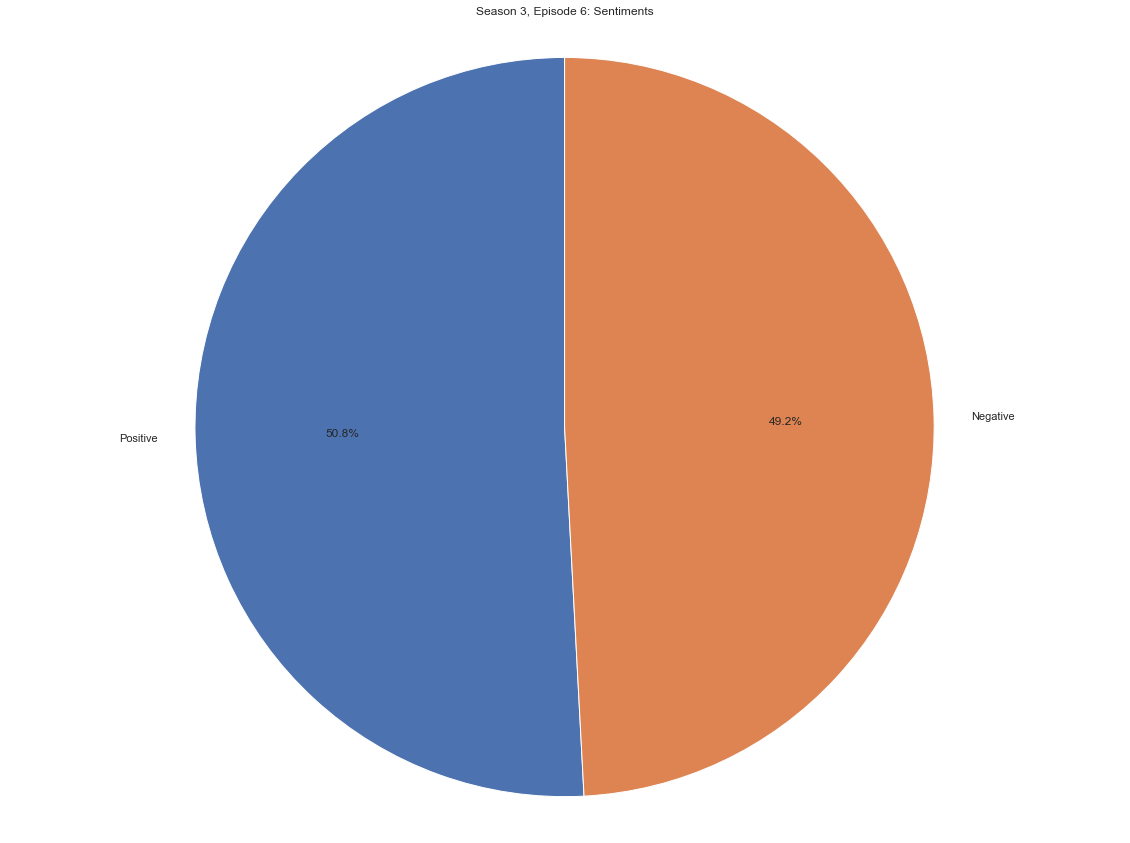

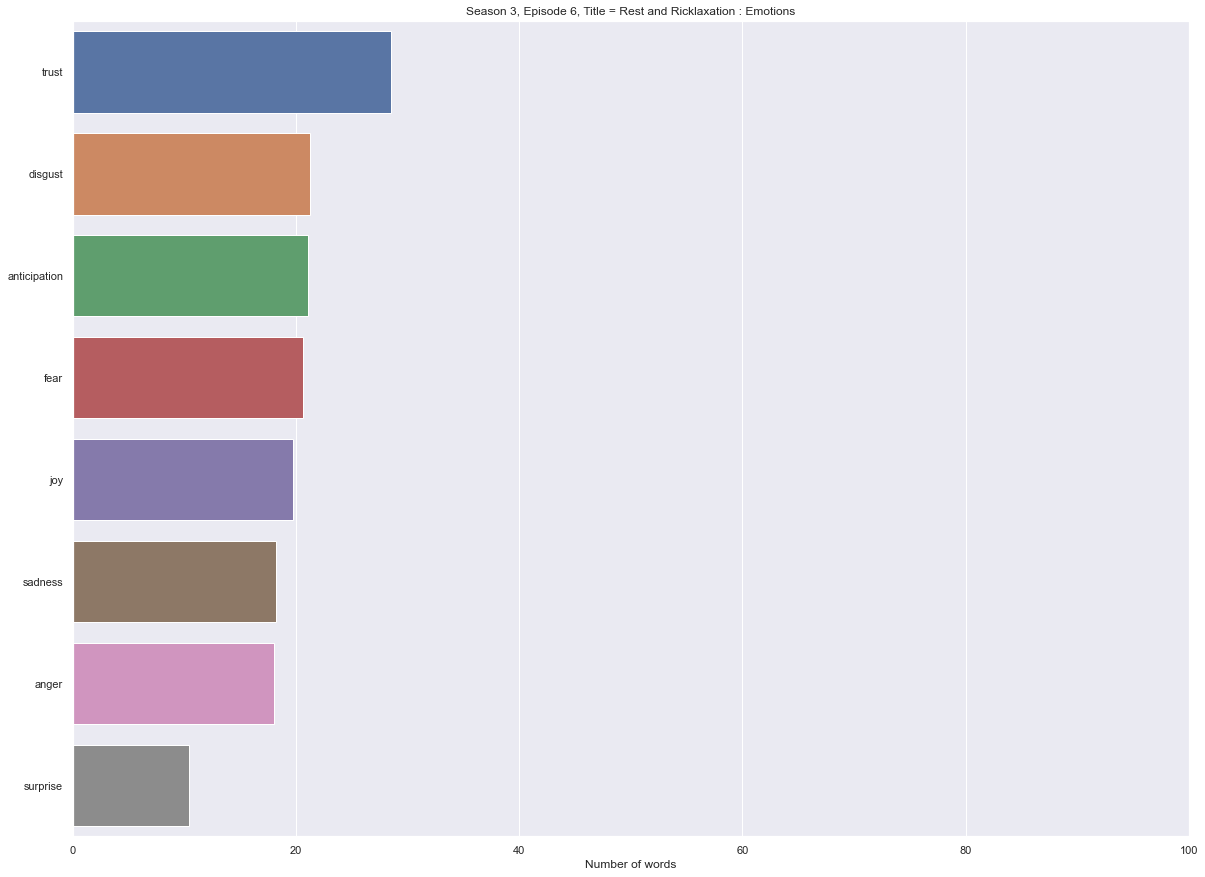

In [27]:
piechart_episode_sentiments(3,6),
plot_seaborn_episode_emotions(3,6)

## Sentiments through seasons

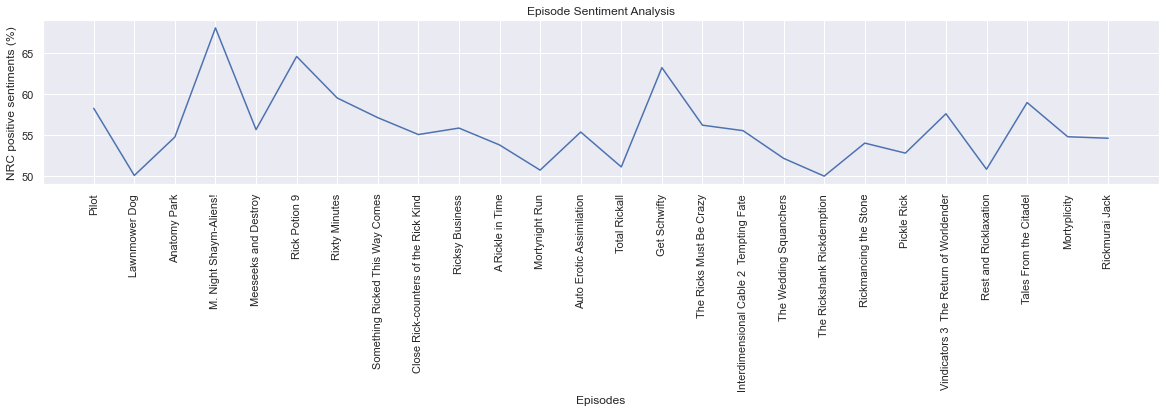

In [28]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df_NRC_episodes['episode name'], df_NRC_episodes.Positive_portion)
plt.xticks(rotation=90)
plt.title("Episode Sentiment Analysis", )
plt.xlabel("Episodes")
plt.ylabel("NRC positive sentiments (%)")
plt.show()

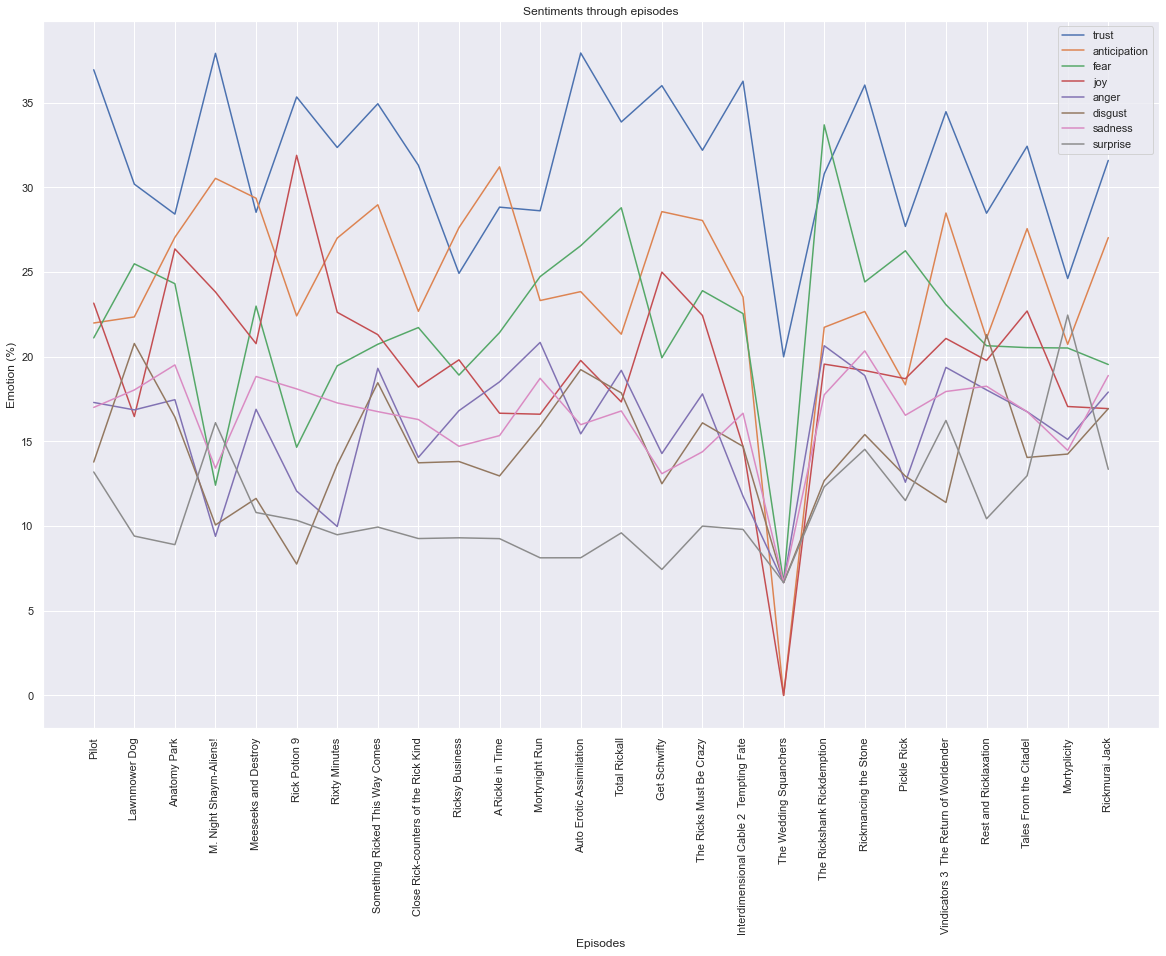

In [30]:
# Plot emotions
emotions = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']
plt.rcParams["figure.figsize"] = (20,13)
plt.rcParams["legend.loc"] = 'upper right'
    
for em in emotions:

    episodes = df_NRC_episodes['episode name']
        
    y = []
    for ep in episodes:
        y.append(df_NRC_episodes[df_NRC_episodes['episode name'] == ep].Emotions_portion.values[0][em])
                     
    plt.plot(episodes, y, label = em)
        
        
plt.xticks(rotation=90)
plt.title("Sentiments through episodes")
plt.xlabel("Episodes")
plt.ylabel("Emotion (%)")
plt.legend()
    
plt.show()

# Sentiment Analysis of Characters Through Episodes 

In [31]:
# def calculate_NRC_sentiment_of_a_character_by_episode(aRow):
#     if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(episodes_dialogue.keys()):
#         sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
        
#         count = 0
#         for word in get_list_of_tokens(episodes_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
#             if (word in list(df_nrc.word)):
#                 count+=1
        
        
#         sentiment_NRC_list.append(sentiment_NRC) 
#         count_list.append(count)
        
#     else:
#         sentiment_NRC_list.append(None)
#         count_list.append(None)


In [32]:
def character_evolvement_NRC(name): 
    
    
    df_char_episode_lines = df_transcripts.groupby(['season no.', 'episode no.', 'episode name', 'name'], as_index = False).agg({'line': ' '.join})
    df_char_episode_lines.line = df_char_episode_lines.line.apply(lambda x: remove_stopwords(x))
    
    df_aChar_lines = df_char_episode_lines[df_char_episode_lines.name == name ].drop('name', axis = 1)
    aChar_dialogue = df_aChar_lines.set_index(['season no.', 'episode no.', 'episode name']).T.to_dict('records')[0]
    sentiment_NRC_list = []
    count_list = []

    
    def calculate_NRC_sentiment_of_a_character_by_episode(aRow):
        if (aRow['season no.'], aRow['episode no.'], aRow['episode name']) in list(aChar_dialogue.keys()):
            sentiment_NRC = calculate_nrc_sentiments(get_list_of_tokens(aChar_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]))
         #   print(sntiment_NRC)
            count = 0
            for word in get_list_of_tokens(aChar_dialogue[(aRow['season no.'], aRow['episode no.'], aRow['episode name'])]):
                if (word in list(df_nrc.word)):
                    count+=1


            sentiment_NRC_list.append(sentiment_NRC) 
            count_list.append(count)

        else:
            sentiment_NRC_list.append(None)
            count_list.append(None)


    _ = df_aChar_lines.apply(calculate_NRC_sentiment_of_a_character_by_episode, axis=1)


    # store in dataframe of characters as a new column
    df_aChar_lines['NRC_score'] = sentiment_NRC_list
    df_aChar_lines['NRC_words'] = count_list
    df_NRC_char_through_ep = df_aChar_lines[df_aChar_lines.NRC_score.notnull()]
    df_NRC_char_through_ep = df_NRC_char_through_ep[df_NRC_char_through_ep.NRC_words != 0]
        
        
    NRC_emotions_list = []
    positive_list = []
    negative_list = []
    positive_portion_list = []
    negative_portion_list = []
    NRC_emotions_portion_list = [] 
        
        
    def calculate_NRC_portions_of_a_character_through_episodes(aRow):
        
        dictEp = df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == aRow['episode name']]['NRC_score'].values[0]
    
        positive = dictEp['positive'] + dictEp['trust'] + dictEp['anticipation'] + dictEp['joy'] + dictEp['surprise']
        negative = dictEp['negative'] + dictEp['fear'] + dictEp['anger'] + dictEp['disgust'] + dictEp['sadness']
        keys = list(dictEp.keys())
        keys.remove('positive')
        keys.remove('negative')
        emotions_dict  =  { k: dictEp[k] for k in keys}

        count = df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == aRow['episode name']]['NRC_words'].values[0]

        emotions_portion_dict = { k: emotions_dict[k] / count * 100 for k in keys}
        positive_portion = positive / (positive + negative) * 100
        negative_portion = negative / (positive + negative) * 100


        NRC_emotions_list.append(emotions_dict)
        NRC_emotions_portion_list.append(emotions_portion_dict)
        positive_list.append(positive)
        negative_list.append(negative)
        positive_portion_list.append(positive_portion)
        negative_portion_list.append(negative_portion)



    
    _ = df_NRC_char_through_ep.apply(calculate_NRC_portions_of_a_character_through_episodes, axis=1)

    # store in dataframe of characters as a new column
    df_NRC_char_through_ep['Positive'] = positive_list
    df_NRC_char_through_ep['Positive_portion'] = positive_portion_list
    df_NRC_char_through_ep['Negative'] = negative_list
    df_NRC_char_through_ep['Negative_portion'] = negative_portion_list
    df_NRC_char_through_ep['Emotions'] = NRC_emotions_list
    df_NRC_char_through_ep['Emotions_portion'] = NRC_emotions_portion_list
    
        

    # Plot sentiments 
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(df_NRC_char_through_ep['episode name'], df_NRC_char_through_ep.Positive_portion)
    plt.xticks(rotation=90)
    plt.title(name + "'s sentiments through episodes")
    plt.xlabel("Episodes")
    plt.ylabel("NRC positive sentiments (%)")
    plt.show()

    
    # Plot emotions
    emotions = ['trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']
    plt.rcParams["figure.figsize"] = (20,8)
    plt.rcParams["legend.loc"] = 'upper right'
    
    for em in emotions:

        episodes = df_NRC_char_through_ep['episode name']
        
        y = []
        for ep in episodes:
            y.append(df_NRC_char_through_ep[df_NRC_char_through_ep['episode name'] == ep].Emotions_portion.values[0][em])
                     
        plt.plot(episodes, y, label = em)
        
        
    plt.xticks(rotation=90)
    plt.title(name + "'s sentiments through episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Emotion (%)")
    plt.legend()
    
    plt.show()


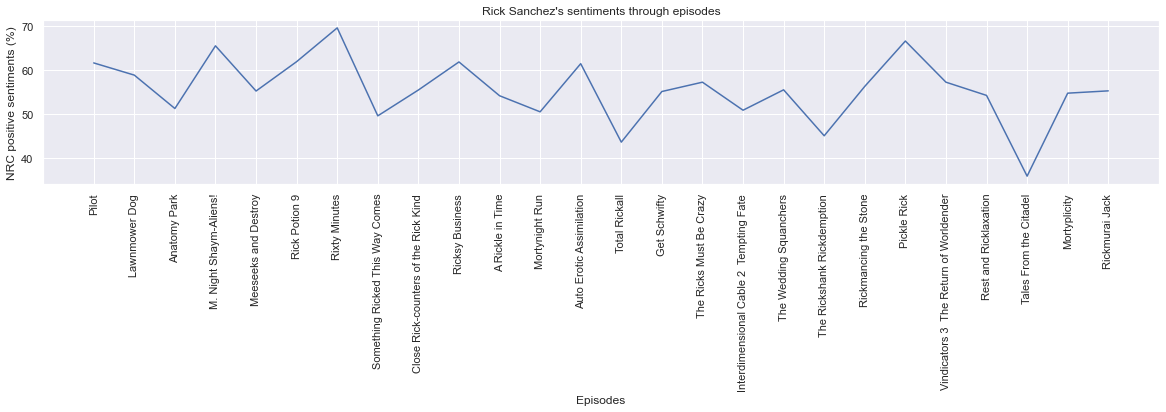

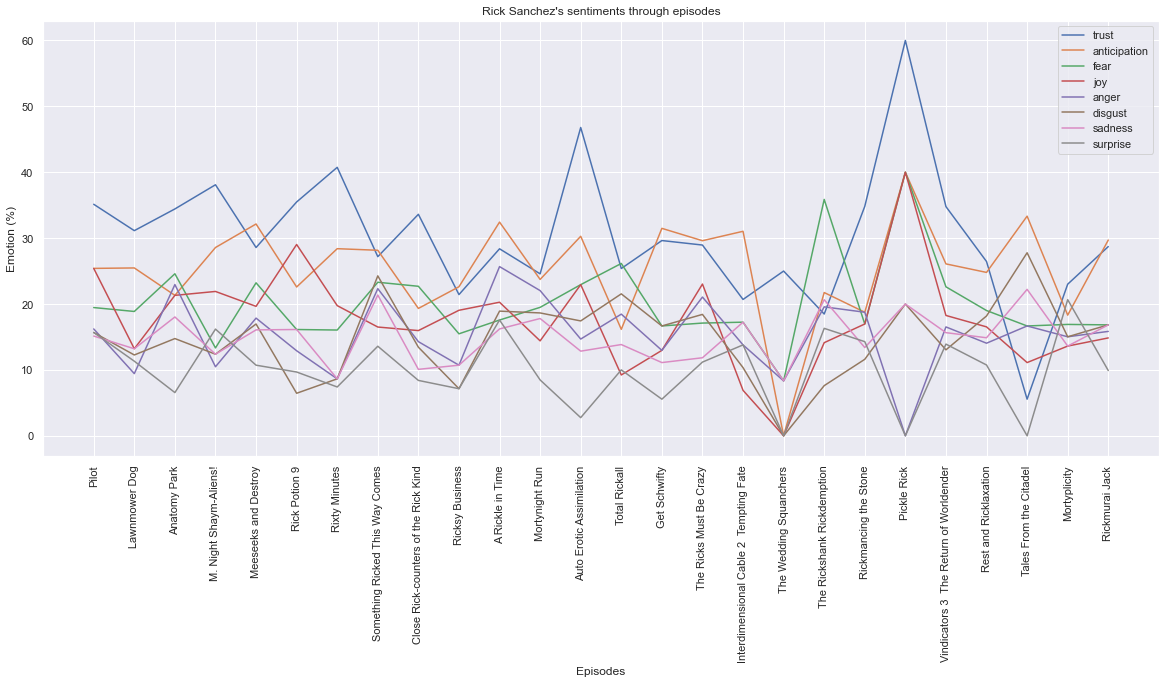

In [33]:
character_evolvement_NRC('Rick Sanchez')


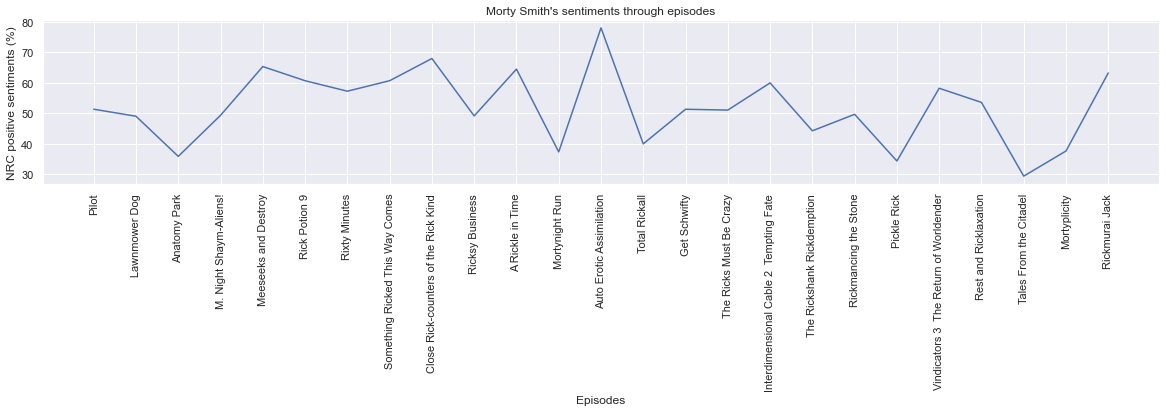

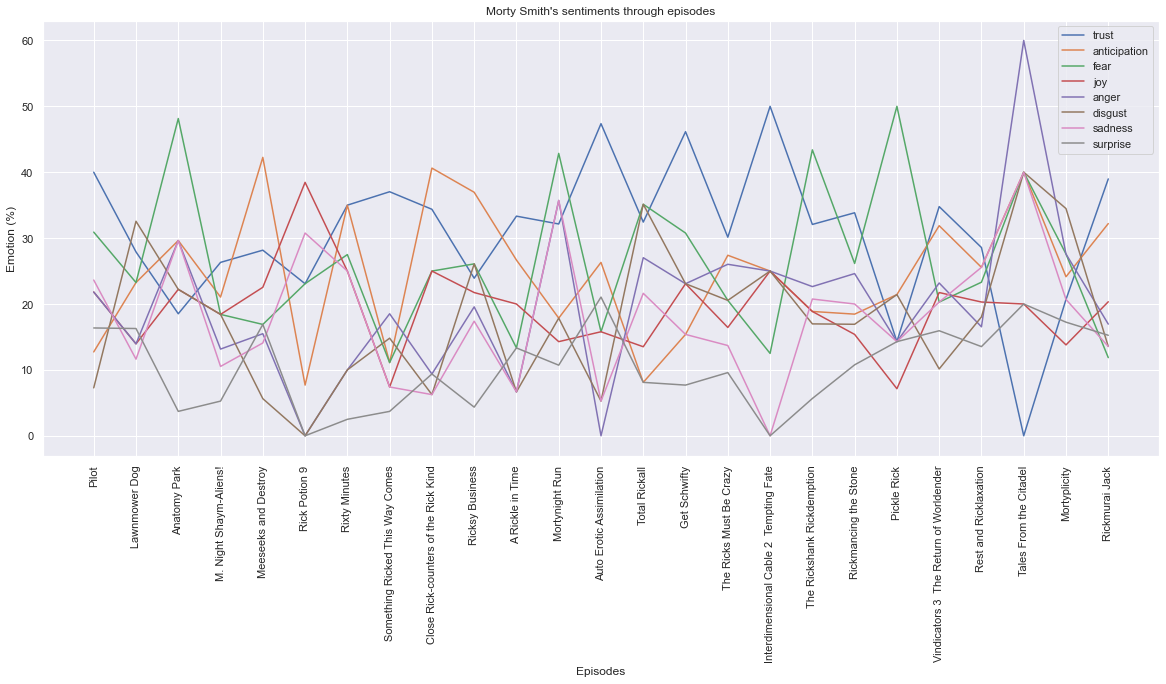

In [34]:
character_evolvement_NRC('Morty Smith')